Расчет поверхности отклика с помощью Латинского гиберкуба

In [8]:
# Импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pyDOE2 import bbdesign, ccdesign, lhs
import pyDOE3 as doe


from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error


# импортируем функции
from functions import generate_random_array, plot_true_vs_predicted,  Functions

In [9]:
# 1. СОЗДАЕМ ПЛАН ЭКСПЕРИМЕНТА
n_samples = 100 # количество численных экспериментов
n_features = 3 # количество признаков

# Используем латинский гиперкуб для равномерного заполнения пространства
X_lhc = doe.lhs(n_features,samples=n_samples,
                    criterion='maximin',  # максимизировать минимальное расстояние между точками
                    seed = 1488)

In [10]:
# Матрица планирования численного эксперимента Box–Behnken
X_bbd = bbdesign(n_features)  # при n=3 даёт 15 точек: 12 + 3 центра
# Оставим только уникальные точки:
X_bbd = np.unique(X_bbd, axis=0)
# Матрица планирования численного эксперимента Central-Composite
X_ccd = ccdesign (n_features)
# Оставим только уникальные точки:
X_ccd = np.unique(X_ccd, axis=0)

# Назначим матрицу планирования с которой далее будем работать
X = X_lhc

# посчитаем количество численных экспериментов
n_samples = X.shape[0]
print (f'Матрица планирования (n_features={n_features}):')
#print (X)
print (f'Количество численных экспериментов: n_samples = {n_samples} ')

Матрица планирования (n_features=3):
Количество численных экспериментов: n_samples = 100 


In [11]:
# Исходные данные в натуральном масштабе
# создаем объект класса Functions 
main_function = Functions()


# определяем количество численных экспериментов
main_function.n_samples = n_samples


# пределы варьирования признаков
main_function.limits = (-10, 10)

# определяем вид функции
main_function.set_function(main_function.trigonometric)

if main_function.n_features != n_features:
    raise ValueError ('Количество признаков в функции {main_function.function_name} не соответсвует количеству признаков занданной \
                        ранее матрицы плана')


# переводим кодированный масштаб в натуральный
main_function.coded_to_natural(X)


In [12]:
# Создаём пайплайн: полином 2-й степени + линейная регрессия
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=True)),
    ('linreg', LinearRegression())
])

# Обучаем
model.fit(main_function.features, main_function.target)

# Оценка качества
y_pred = model.predict(main_function.features)
print("R² на обучающих данных:", r2_score(main_function.target, y_pred))

R² на обучающих данных: 0.09468537086386675


In [13]:
poly = model.named_steps['poly']
linreg = model.named_steps['linreg']

# Имена признаков в полиноме
feature_names = poly.get_feature_names_out([f'x{i+1}' for i in range(main_function.n_features)])

# Вывод коэффициентов
coeffs = pd.DataFrame({
    'term': feature_names,
    'coefficient': linreg.coef_
})
coeffs.loc[0, 'coefficient'] += linreg.intercept_  # свободный член уже включён, если include_bias=True

print("\nКоэффициенты модели:")
print(coeffs)


Коэффициенты модели:
    term  coefficient
0      1    -1.166637
1     x1     0.063254
2     x2     0.293045
3     x3     0.192610
4   x1^2     0.000183
5  x1 x2    -0.006926
6  x1 x3    -0.008425
7   x2^2    -0.024986
8  x2 x3    -0.007323
9   x3^2    -0.013129


In [14]:
# проверка полученной модели
# Генерация пула кандидатов (случайные точки в допустимом диапазоне)
rng = np.random.default_rng(seed=1488)
X_pool = rng.uniform(low=main_function.limits[0], high=main_function.limits[1], size=(10000, main_function.n_features))
y_pool = main_function.function(*X_pool.T)

# Кодирование массива признаков X_pool
X_pool_codded = main_function.natural_to_coded(X_pool)
# Расчитываем отклик
y_pred_big_test = model.predict(X_pool) 
print("R² на данных для проверки:", r2_score(y_pool, y_pred_big_test))

R² на данных для проверки: -15.632654418348498


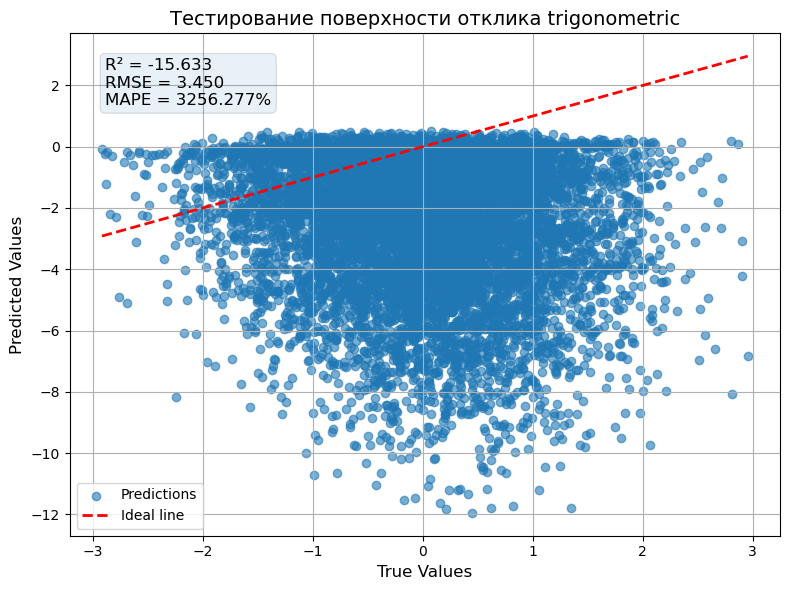

In [15]:
# посмотрим на график паритета
plot_true_vs_predicted (y_pool, y_pred_big_test, title= f'Тестирование поверхности отклика {main_function.function_name}')

In [17]:
def adaptive_nonlinear_design(initial_points=50, iterations=3):
    """Адаптивный план для сильно нелинейных функций"""
    import pyDOE3 as doe
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel
    
    bounds = [[-10, 10], [-10, 10], [-10, 10]]
    all_points = []
    
    # Начальный план (LHS)
    X_current = doe.lhs(3, samples=initial_points, criterion='maximin', seed=42)
    for i in range(3):
        X_current[:, i] = X_current[:, i] * 20 - 10
    
    for iteration in range(iterations):
        # Добавляем текущие точки
        all_points.append(X_current)
        
        # Вычисляем функцию в этих точках
        y_current = np.array([main_function.trigonometric(*x) for x in X_current])
        
        # Строим GP модель для оценки неопределенности
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gp.fit(X_current, y_current)
        
        # Генерируем кандидатов для следующей итерации
        n_candidates = 1000
        candidates = doe.lhs(3, samples=n_candidates, seed=iteration)
        for i in range(3):
            candidates[:, i] = candidates[:, i] * 20 - 10
        
        # Предсказываем с неопределенностью
        y_pred, sigma = gp.predict(candidates, return_std=True)
        
        # Выбираем точки с максимальной неопределенностью
        # (здесь функция может быть наиболее нелинейной)
        n_new = 20
        idx_new = np.argsort(sigma)[-n_new:]
        X_current = candidates[idx_new]
    
    return np.vstack(all_points)

X_adaptive = adaptive_nonlinear_design(initial_points=50, iterations=3)
print(f"Адаптивный план: {len(X_adaptive)} точек")

/home/alexander/miniconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Адаптивный план: 90 точек


/home/alexander/miniconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
